In [1]:
from mapd.visualization.visualization_tool import MAPDVisualizationTool

In [2]:
import dill as pickle

with open("probe_suite_ds.pkl", "rb") as f:
    probe_suite_dataset = pickle.load(f)

In [3]:
tool = MAPDVisualizationTool(mapd_loss_dataset_path="mapd_probes", probe_suite_dataset=probe_suite_dataset)

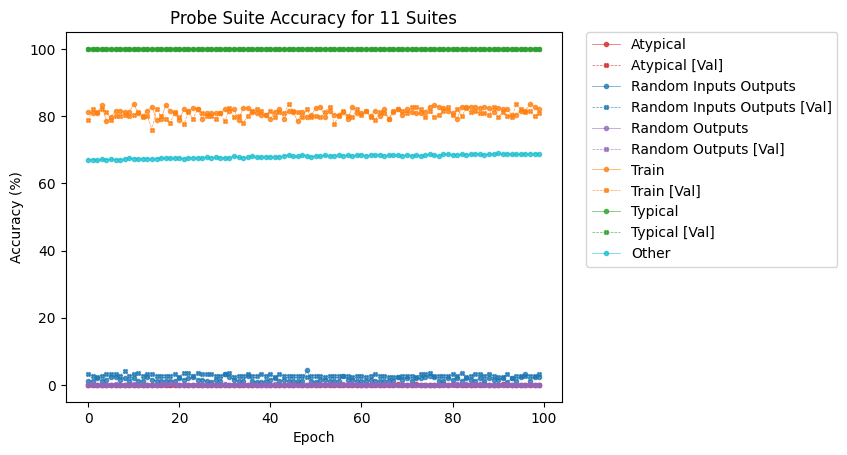

In [4]:
tool.probe_accuracy_plot()